# Seminar #2: Levenstein distance and Word Error Rate

Over the last decade there have been drastic improvements to the quality of ASR systems. However, in whats units and how is the quality of an ASR quality measured? Word (Character, Phoneme) Error Rate (WER/CER/PER) – are the most popular metrics, which try to approximate how we perceive errors in the speech we hear.

In this seminar, we you will learn to calculate each of these distances using the Levenstein distance. You will implement both a naive recursive version of the Levenstein algorithm as well as a more efficient dynamic-programming implementation. Then, using your implementation of Levenstein distance you wil compute ASR quality metrics.

### Grading criteria

```
[ ] (3 point)  Naive Levenstein Algorithm
[ ] (3 point)  Wagner-Fischer Algorithm
[ ] (3 points) Backtrace
[ ] (1 point)  Assessing Error
```

### Submitting results

The results of this task are one artifact:
1. this Jupiter Notebook (`.ipynb`) with completed cells

Save the artifact to a directory named `{your last name}_{your first name}_sem2` and pack them in `.zip` archive.

![human performance wer](https://awni.github.io/images/speech-recognition/wer.svg)

# Setup

In [ ]:
from typing import List, Iterable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Levenshtein distance

## Theoretical Recap

Consider an iterable sequence of elements, such as word or characters. Assume that the following operations can be performed on the sequence:
* **insertion**: cat → ca<font color='green'>s</font>t,
* **deletion**: ca<font color='red'>s</font>t → cat,
* **substitution**: c<font color='blue'>a</font>t → c<font color='blue'>u</font>t,

and suppose they have equal **costs**. These operations are enough to translate an arbitrary sequence into a different arbitrary sequence. There are many ways in which we can transform (edit) the sequence into a difference sequence. Given two sequences A and B, our goal is to find the minimum number of edits which are needed to transform sequence A into sequence B. This is known as the **Levenstein Distance**.

<!-- ### Algorithm definition -->

**Levenshtein distance** – the minimum number insertions, deletions, and substitutions required to transform sequence A into sequence B.


The Levenstein distance can be computed using the following recursive algorithm, known as the **Levenstein Algorithm**:

$$
\mathrm{L}(a, b) =
\begin{cases}
    |a|,& \text{if } |b| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# second sequence is empty} \\
    |b|,& \text{if } |a| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# first sequence is empty} \\
    \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)),& \text{if } \mathrm{head}(a) = \mathrm{head}(b), ~ ~ \text{# first elements of two sequencies are equal} \\
    1 + min 
    \begin{cases} 
        \mathrm{L}(\mathrm{tail}(a), b), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# deletion from first sequence} \\ 
        \mathrm{L}(a, \mathrm{tail}(b)), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# insertion into first sequence} \\ 
        \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)); ~ ~ ~ ~ \text{# substitution}
    \end{cases} & \text{, otherwise.}
\end{cases}
$$

<!-- %%
\text{lev}(a,b) = \left \{
  \begin{aligned}
    &\text{len}(a), & \text(del)& &&\text{if}\ \text{len}(b)=0, \\
    &\text{len}(b), & \text(ins)& &&\text{if}\ \text{len}(a)=0, \\
    &\text{lev}(a[1:],b[1:]) & \text(cor)& &&\text{if}\ a[0] = b[0], \\
    &1+\min\left \{
  \begin{aligned}
    &\text{lev}(a[1:],b) & \text(del)\\
    &\text{lev}(a,b[1:]) & \text(ins)\\
    &\text{lev}(a[1:],b[1:]) & \text(sub/cor)
  \end{aligned} \right. && &&\text{otherwise}
  \end{aligned} \right.
%% -->

As you can see, the Levenshtein distance is a metric in the mathematical sense (symmetry, positive certainty, triangle inequality).

**Question: what is the complexity of this algorithm?**


## Naive recursive implementation (3 points)

Let's try to implement the recursive algorithm described above.

In [ ]:
def levenshtein_naive(a: Iterable, b: Iterable) -> int:
    """Recursive implementation of Levenshtein distance

    :param a: Iterable
    :param b: Iterable
    :return distance: int
    """

    #############################################
    <YOUR CODE>
    #############################################

In [ ]:
# Assess algorithm correctness
def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3
    
run_tests(levenshtein_naive)

##  Wagner–Fischer algorithm (3 points)

The complexity of the naive recursive implementation of the Levenshtein distance algorithm is exponential. This is due to the fact that the distances for the same suffixes are recalculated more than once! This can be avoided if we cache the results of calculations in the form of a matrix of distances between suffixes (more conveniently, prefixes), and fill in this matrix iteratively. The resulting algorithm is named **Wagner–Fischer algorithm** and is an example of a __dynamic programming__ algorithm.

The Wagner-Fisher algorithm is defined as follows:


$$
  \mathrm{L}_{a,b}(i,j) = \left \{
  \begin{aligned}
    &\max(i,j), && &&\text{if}\ \min(i,j)=0, \\
    &\min\left \{
  \begin{aligned}
    &\mathrm{L}_{a,b}(i-1,j)+1 & \text(del)\\
    &\mathrm{L}_{a,b}(i,j-1)+1 & \text(ins)\\
    &\mathrm{L}_{a,b}(i-1,j-1)+\delta(a_i \neq b_j) & \text(sub)
  \end{aligned} \right. && &&\text{otherwise}
  \end{aligned} \right.
$$


**Implement** the `levenshtein_distance_matrix` function, which returns **the distance matrix between the prefixes of the two sequences**. The lower-right element of this matrix is the distance between the prefixes that are equal to the original sequences.

It is necessary to fill in this matrix line by line: for a new element of this matrix, it is enough to know only its neighbors to the left, top, and left-top.

We will also prepend an element denoting an **empty prefix** to the sequences – this is done in order to initialize the initial boundary values (initialize the first row and the first column of the matrix with the index values).



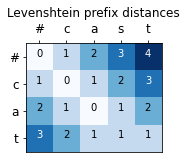

In [ ]:
# Auxiliary function for drawing this matrix:
def plot_matrix(matrix, row_names, column_names, path=None, mods=None):
    """
    :param matrix: np.array [n_rows, n_cols] levenstein distance matrix
    :param row_names: Name of the row elements
    :param column_names: Name of the column elements
    :param path: 
    :param mods: 
    :return: None
    """
    row_names = ['#'] + list(row_names)
    column_names = ['#'] + list(column_names)
    matrix = np.array(matrix)
    
    plt.figure(figsize=(len(column_names) / 2, len(row_names) / 2))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title("Levenshtein prefix distances")
    
    r = 0 if max(map(len, row_names + column_names)) < 3 else 45
    plt.gca().xaxis.tick_top()
    plt.xticks(range(len(column_names)), column_names, fontsize=12, rotation=r)
    plt.yticks(range(len(row_names)), row_names, fontsize=12, rotation=r)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            kwargs = {
                'color': "white" if matrix[i, j] > matrix.max() / 2 else "black",
                'horizontalalignment': 'center'
            }
            plt.text(j, i, "{:,}".format(matrix[i, j]), **kwargs)
    
    if path is not None:
        for (i, j), mod in zip(path, mods):
            colors = {
                'same': '#888888',
                'subst': '#0000ff',
                'del': '#ff0000',
                'insert': '#00ff00'
            }
            
            rect = patches.Rectangle(
                (j - 0.45, i - 0.45), 0.9, 0.9, 
                edgecolor=colors[mod], facecolor='none', linewidth=2)
            plt.gca().add_patch(rect)
            
    plt.show()


plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
], 'cat', 'cast')

In [ ]:
def levenshtein_distance_matrix(a: Iterable, b: Iterable) -> np.ndarray:
    """Matrix implementation of Levenshtein distance

    :param a: Iterable
    :param b: Iterable
    :return distance matrix: np.ndarray
    """
    a = ['#'] + list(a)
    b = ['#'] + list(b)
    d = np.zeros((len(a), len(b)), dtype=int)

    #############################################
    <YOUR CODE>
    #############################################
    
    return d

def levenshtein_dp(a: Iterable, b: Iterable) -> int:
    return levenshtein_distance_matrix(a, b)[-1, -1]

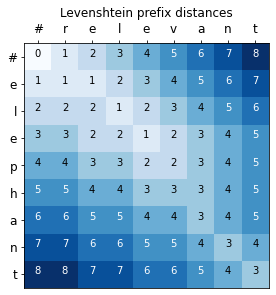

In [ ]:
# first, second = 'sunday', 'saturday'
first, second = 'elephant', 'relevant'
plot_matrix(levenshtein_distance_matrix(first, second), first, second)

def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3

    import random
    for _ in range(100):
        first = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        second = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        assert fn(first, second) == levenshtein_naive(first, second)
        
# lets check our implementation on random sequences
run_tests(levenshtein_dp)

## Backtrace (3 points)

To understand what insertions, deletions and substitutions were made on the original sequence, you can do a backtrace on the resulting matrix. 

Let's consider the first sequence as the original one, abd we will call the deletions and inserts relative to it.

**Implement** the `backtrace` function, based on the construction logic `levenshtein_distance_matrix`:
* write the path to the variable `path` – the list of the coordinates of the matrix cells that lie on the optimal path through the matrix;
* and in the `mods` variable, write down the modifications that we make on the original sequence:
    * `same` - leaving the element unchanged
    * `subst` - replacing the element
    * `del` - deleting the element
    * `insert` - inserting the element

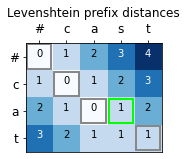

In [ ]:
plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
],
    'cat', 'cast', 
    [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4)], 
    ['same', 'same', 'same', 'insert', 'same'])

In [ ]:
def backtrace(d : np.ndarray):
    """Backtrace for Levenstein Distance

    :param d: Levenstein Distance matrix (np.ndarray)
    :return path:
    :return path:
    """
    path = []
    mods = []
    
    ##########################################
    <YOUR CODE>
    ##########################################

    return path, mods

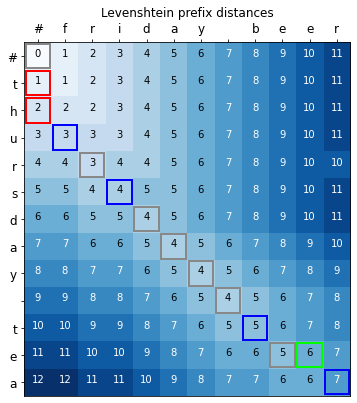

In [ ]:
first, second = 'thursday tea', 'friday beer'

path, mods = backtrace(levenshtein_distance_matrix(first, second))
plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

Let's try applying the Levenshtein distance to a sequence of words, not characters.

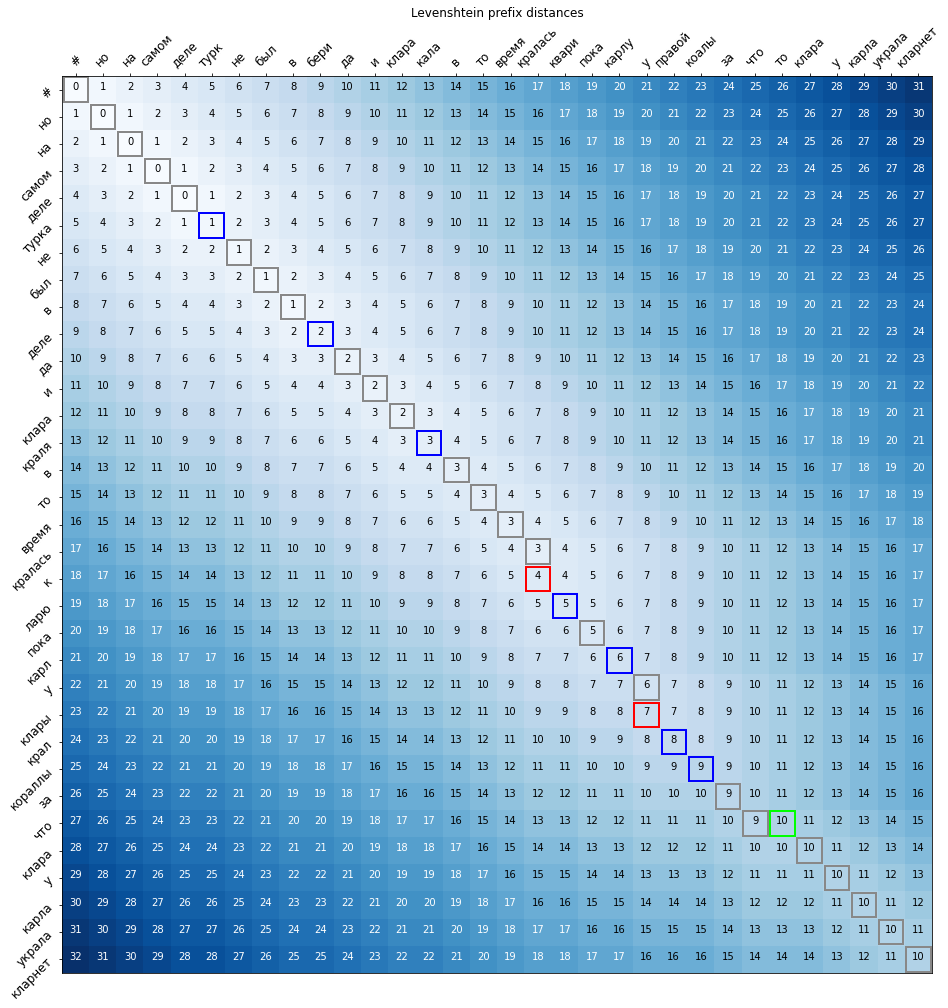

In [ ]:
first = "но на самом деле турка не был в деле да и клара краля в то время кралась к ларю пока карл у клары крал кораллы за что клара у карла украла кларнет".split()
second = "но на самом деле турк не был в бери да и клара кала в то время кралась квари пока карлу у правой коалы за что то клара у карла украла кларнет".split()

path, mods = backtrace(levenshtein_distance_matrix(first, second))
plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

In [ ]:
# Assess backtrace

D = (np.array(mods) == 'del').sum()
S = (np.array(mods) == 'subst').sum()
I = (np.array(mods) == 'insert').sum()
print(f"S: {S}")
print(f"I: {I}")
print(f"D: {D}")

assert S == 7
assert I == 1
assert D == 2

S: 7
I: 1
D: 2


# Assessing Error (1 point)

In this part you will use the Levenstein distance which you implemented in the first part to obtain an measure of __mistmatch__ or __error__ between a reference and an ASR hypothesis at the word, character and phone level.

## Theoretical Recap

Suppose we have our reference sequence, relative to which we want to calculate the recognition error.

Why do you think the Levenshtein distance is not suitable for measuring the quality of the ASR system because the number of tokens in sentence can be different. Therefore, we need to normalize the Levenshtein distance by the length of the reference. This years our minimum edit distance **rate**.

Word (character, phoneme, morpheme, syllable) error rate can then be computed as:

$$
\mathrm{WER} = \frac{\mathrm{S} + \mathrm{I} + \mathrm{D}}{\mathrm{N}}, \text{where:} \\
\text{S is the number of substitutions,} \\
\text{I is the number of insertions,} \\
\text{D is the number of deletions,} \\
\text{N is the length of reference.}
$$

We can assess the error rate between two sequences at multiple levels - the word level (WER), the character (letter) level (CER) and the phoneme level (PER). WER is the most strict, as even a partially correct word is considered incorrect. Phone Error rate is in some sense the most lenient, as is measures whether the reference and hypthesis "sound" the same. Note that error can be assessed at other levels, like morphemes, lexemes and syllables, for example. Which metric is appropriate depends on the choice of language and what is being measured.  

## WER vs CER vs PER (1 point)

Implement the `error_rate` function, which will calculate the prediction error for a given sequence of tokens (words, characters or phonemes) by formula above.

In [ ]:
def error_rate(reference: Iterable, predicted: Iterable) -> float:
    assert len(reference) > 0
    
    ######################################
    <YOUR CODE>
    ######################################

In [ ]:
# Assess error rate function

# Calculate WER and CER
first = "но на самом деле турка не был в деле да и клара краля в то время кралась к ларю пока карл у клары крал кораллы за что клара у карла украла кларнет"
second = "но на самом деле турк не был в бери да и клара кала в то время кралась квари пока карлу у правой коалы за что то клара у карла украла кларнет"

wer = np.round(error_rate(first.split(), second.split()), 4)
cer = np.round(error_rate(first, second), 4)

# Calculate PER - we provide a phonetic transcription of the above sentences. 
first = "n o <space> n ɐ <space> s a+ m ə m <space> dʲ e+ lʲ e <space> t u+ r k ə <space> nʲ e <space> b ɨ+ lˠ <space> f <space> dʲ e+ lʲ e <space> d ɐ <space> ɪ <space> k lˠ a+ r ə <space> k r a+ lʲ ə <space> f <space> t ɐ <space> v rʲ e+ mʲ ə <space> k r a+ lˠ ə sʲ <space> k <space> lˠ ɐ rʲ u+ <space> p ɐ k a+ <space> k a+ r lˠ <space> ʊ <space> k lˠ a+ r ɨ <space> k r a+ lˠ <space> k ɐ r a+ lˠ ɨ <space> z ɐ <space> t͡ɕ t ɐ <space> k lˠ a+ r ə <space> ʊ <space> k a+ r lˠ ə <space> ʊ k r a+ lˠ ə <space> k lˠ ɐ r nʲ e+ t"
second = "n o <space> n ɐ <space> s a+ m ə m <space> dʲ e+ lʲ e <space> t u+ r k <space> nʲ e <space> b ɨ+ lˠ <space> f <space> bʲ e+ rʲ ɪ <space> d ɐ <space> ɪ <space> k lˠ a+ r ə <space> k a+ lˠ ə <space> f <space> t ɐ <space> v rʲ e+ mʲ ə <space> k r a+ lˠ ə sʲ <space> k v ɐ rʲ i+ <space> p ɐ k a+ <space> k a+ r lˠ ʊ <space> ʊ <space> p r a+ v ə j <space> k ɐ a+ lˠ ɨ <space> z ɐ <space> t͡ɕ t ɐ <space> t ɐ <space> k lˠ a+ r ə <space> ʊ <space> k a+ r lˠ ə <space> ʊ k r a+ lˠ ə <space> k lˠ ɐ r nʲ e+ t"
per = np.round(error_rate(first.split(), second.split()), 4)

print('Word Error Rate:', wer)
print('Character Error Rate:', cer)
print('Phone Error Rate:', per)

assert np.allclose(wer, 0.3125, rtol=1e-5, atol=1e-5)
assert np.allclose(cer, 0.1644, rtol=1e-5, atol=1e-5)
assert np.allclose(per, 0.1597, rtol=1e-5, atol=1e-5)

Word Error Rate: 0.3125
Character Error Rate: 0.1644
Phone Error Rate: 0.1597
